In [1]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd
import sys,os
import glob
import crflux.models as mods
import gsf
from methods import *
import scipy.stats
import joblib
from tensorflow.keras.models import load_model
from functools import partial
from scipy.optimize import curve_fit
import matplotlib
from scipy.stats import chisquare

In [2]:
Energy = np.linspace(10**6.5,10**8,10000)

In [3]:
corsika_id = [14,402,1608,5426]

In [4]:
data = pd.read_csv('files/data.csv')
data = new_df_data(data)

/home/andy/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [5]:
test_data = pd.read_csv('test_data.csv')

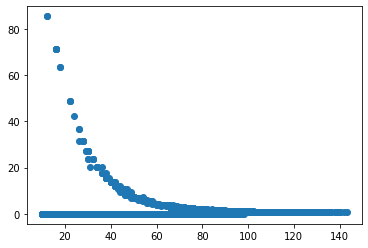

In [6]:
plt.scatter(test_data['N'],test_data['waveform_weight'])
plt.show()

/home/andy/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


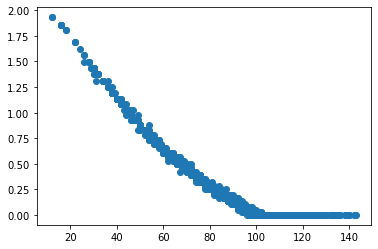

In [7]:
plt.scatter(test_data['N'],np.log10(test_data['waveform_weight']))
plt.show()

In [8]:
len(data)

44212

In [9]:
def xmax_model(df):
    inputs = ['cos_zenith','S125','log_energy_loss','he_stoch','he_stoch2','m_r','m_o','s_mean','s_std','A']
    files = np.sort(np.array(glob.glob('files/model_coinc_best_*.h5')))
    correction = np.sort(np.array(glob.glob('files/Xmax_bias_correction*')))
    prediction = []
    for i in range(len(files)):
        model = load_model(files[i]) 
        bias = joblib.load(correction[i])
        xmax = model.predict(df[inputs])[:,1]
        bias_value = bias.predict(xmax.reshape(-1,1))
        xmax_predictions = np.array([(i-j) for i,j in zip(xmax,bias_value)])
        prediction.append(xmax_predictions)
    output = np.array([np.mean(i) for i in list(zip(*prediction))])
    return output

In [10]:
def mass_model(df):
    inputs = ['cos_zenith','S125','log_energy_loss','he_stoch','he_stoch2','m_r','m_o','s_mean','s_std','A']
    files = np.sort(np.array(glob.glob('files/mass_model_*')))
    prediction = []
    for i in range(len(files)):
        model = joblib.load(files[i]) 
        mass = model.predict(df[inputs])
        prediction.append(mass)
    output = np.array([np.mean(i) for i in list(zip(*prediction))])
    return output

In [11]:
def Energy_model(df):
    inputs = ['cos_zenith','S125','log_energy_loss','he_stoch','he_stoch2','m_r','m_o','s_mean','s_std','A']
    files = np.sort(np.array(glob.glob('files/Energy_model*')))
    prediction = []
    for i in range(len(files)):
        model = joblib.load(files[i]) 
        mass = model.predict(df[inputs])
        prediction.append(mass)
    output = np.array([np.mean(i) for i in list(zip(*prediction))])
    return output

In [12]:
energy_data = Energy_model(data)
xmax_data = xmax_model(data)
mass_data = mass_model(data)
energy_data = energy_data

In [13]:
test_energy = Energy_model(test_data)
test_xmax = xmax_model(test_data)
test_mass = test_data['mass'].values

In [14]:
error_energy = [(i-j)**2 for i,j in zip(test_energy,test_data['log_energy'].values)]
error_xmax = [(i-j)**2 for i,j in zip(test_xmax,test_data['Xmax'].values)]

In [15]:
np.mean(error_energy)**0.5,np.mean(error_xmax)**0.5

(0.05645893326167275, 41.62868485304352)

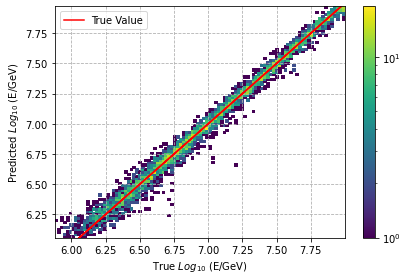

In [16]:
plt.hist2d(test_data['log_energy'].values,test_energy,bins=100,norm=matplotlib.colors.LogNorm())
plt.xlabel('True $Log_{10}$ (E/GeV)')
plt.ylabel('Predicted $Log_{10}$ (E/GeV)')
plt.plot(test_data['log_energy'].values,test_data['log_energy'].values,color='r',label='True Value')
plt.colorbar()
plt.legend()
plt.grid(True,linestyle='dashed')
plt.tight_layout()
plt.savefig('Energy_resolution.png')

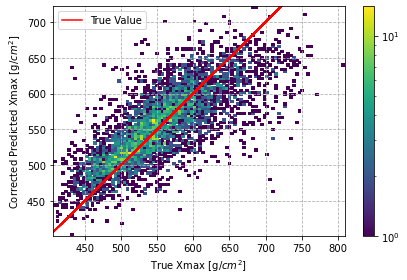

In [17]:
plt.hist2d(test_data['Xmax'].values,test_xmax,bins=100,norm=matplotlib.colors.LogNorm())
plt.plot(test_data['Xmax'].values,test_data['Xmax'].values,color='r',label='True Value')
plt.xlabel('True Xmax [g/$cm^2$]')
plt.ylabel('Corrected Predicted Xmax [g/$cm^2$]')
plt.legend()
plt.colorbar()
plt.tight_layout()
plt.grid(True,linestyle='dashed')
plt.savefig('True_vs_predicted_after.png')

/home/andy/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/andy/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/andy/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:234: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/andy/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:195: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/andy/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


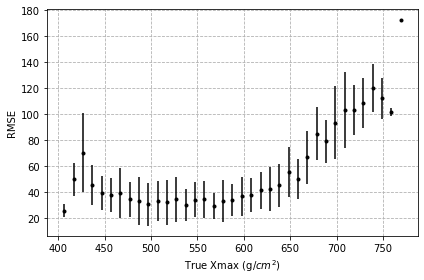

In [18]:
mean_list,mean_overall,std_mean,bins,median,ten,ninety,FWHM = binning2(np.array(test_data['Xmax']),np.array(error_xmax),bins=40)
rmse_new = [i**0.5 for i in mean_overall]
std_new = [(1/(2*mean))*sigma/2 for mean,sigma in zip(rmse_new,std_mean)]
plt.errorbar(bins,rmse_new,yerr=np.array(std_new),fmt='.',color='black')
plt.xlabel('True Xmax (g/$cm^2$)')
plt.ylabel('RMSE')
plt.grid(True,linestyle='dashed')
plt.tight_layout()
plt.savefig('RMSE_Xmax.png')

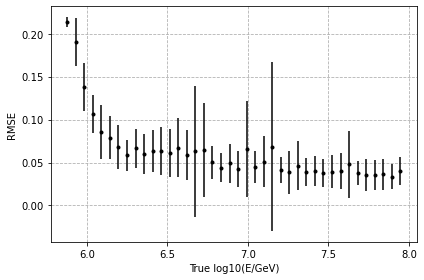

In [19]:
mean_list,mean_overall,std_mean,bins,median,ten,ninety,FWHM = binning2(np.array(test_data['log_energy'].values),np.array(error_energy),bins=40)
rmse_new = [i**0.5 for i in mean_overall]
std_new = [(1/(2*mean))*sigma/2 for mean,sigma in zip(rmse_new,std_mean)]
plt.errorbar(bins,rmse_new,yerr=np.array(std_new),fmt='.',color='black')
plt.xlabel('True log10(E/GeV)')
plt.ylabel('RMSE')
plt.grid(True,linestyle='dashed')
plt.tight_layout()
plt.savefig('RMSE_Energy.png')

In [66]:
hist1 = np.histogram(test_data['log_energy'].values,bins=100)
hist2 = np.histogram(test_energy,bins=100)

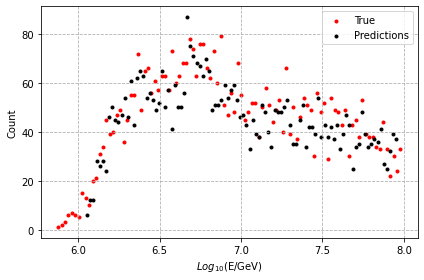

In [67]:
plt.scatter(hist1[1][0:-1],hist1[0],marker='.',color='r',label='True')
plt.scatter(hist2[1][0:-1],hist2[0],marker='.',color='black',label='Predictions')
plt.grid(True,linestyle='dashed')
plt.xlabel('$Log_{10}$(E/GeV)')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.savefig('test_energy.png')

In [64]:
hist1 = np.histogram(test_data['Xmax'].values,bins=100)
hist2 = np.histogram(test_xmax,bins=hist1[1])

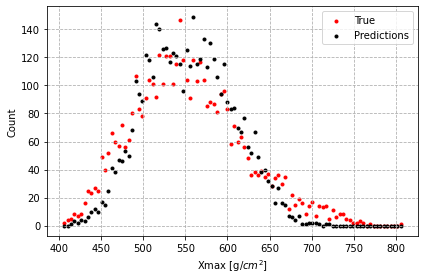

In [65]:
plt.scatter(hist1[1][0:-1],hist1[0],marker='.',color='r',label='True')
plt.scatter(hist2[1][0:-1],hist2[0],marker='.',color='black',label='Predictions')
plt.grid(True,linestyle='dashed')
plt.xlabel('Xmax [g/$cm^2$]')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.savefig('test_xmax.png')

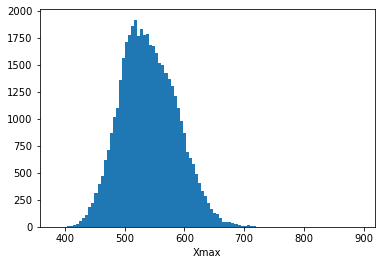

In [20]:
plt.hist(xmax_data,bins=100)
plt.xlabel('Xmax')
plt.savefig('Xmax_data.png')

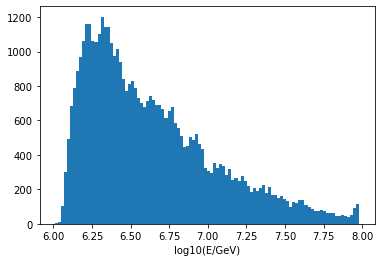

In [21]:
plt.hist(energy_data,bins=100)
plt.xlabel('log10(E/GeV)')
plt.savefig('Energy_data.png')

In [22]:
proton_flux = mods.HillasGaisser2012('H3a').nucleus_flux(14,Energy)
helium_flux = mods.HillasGaisser2012('H3a').nucleus_flux(402,Energy)
oxygen_flux = mods.HillasGaisser2012('H3a').nucleus_flux(1206,Energy)
iron_flux = mods.HillasGaisser2012('H3a').nucleus_flux(5426,Energy)
lnA_H3A = mods.HillasGaisser2012('H3a').lnA(Energy)
total_flux = mods.HillasGaisser2012('H3a').total_flux(Energy)

In [23]:
H3A = mods.HillasGaisser2012('H3a')

In [24]:
proton_flux1 = mods.HillasGaisser2012('H4a').nucleus_flux(14,Energy)
helium_flux1 = mods.HillasGaisser2012('H4a').nucleus_flux(402,Energy)
oxygen_flux1 = mods.HillasGaisser2012('H4a').nucleus_flux(1206,Energy)
iron_flux1 = mods.HillasGaisser2012('H4a').nucleus_flux(5426,Energy)
lnA_H4A = mods.HillasGaisser2012('H4a').lnA(Energy)
total_flux1 = mods.HillasGaisser2012('H4a').total_flux(Energy)

In [25]:
H4A = mods.HillasGaisser2012('H4a')

In [26]:
proton_flux2 = mods.GaisserStanevTilav('4-gen').nucleus_flux(14,Energy)
helium_flux2 = mods.GaisserStanevTilav('4-gen').nucleus_flux(402,Energy)
oxygen_flux2 = mods.GaisserStanevTilav('4-gen').nucleus_flux(1206,Energy)
iron_flux2 = mods.GaisserStanevTilav('4-gen').nucleus_flux(5426,Energy)
lnA_GST = mods.GaisserStanevTilav('4-gen').lnA(Energy)
total_flux2 = mods.GaisserStanevTilav('4-gen').total_flux(Energy)

In [27]:
GST = mods.GaisserStanevTilav('4-gen')

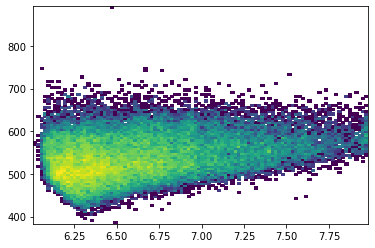

In [28]:
plt.hist2d(energy_data,xmax_data,bins=100,norm=matplotlib.colors.LogNorm())
plt.show()

In [29]:
mean_overall,std_mean,bins,median,ten,ninety = binning(energy_data,xmax_data,20)

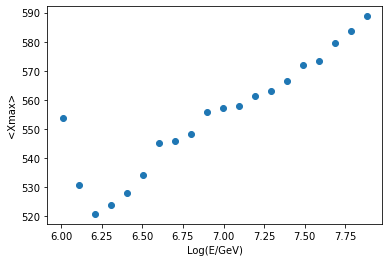

In [30]:
plt.scatter(bins,mean_overall)
plt.xlabel('Log(E/GeV)')
plt.ylabel('<Xmax>')
plt.savefig('Mean_Xmax_plot.png')

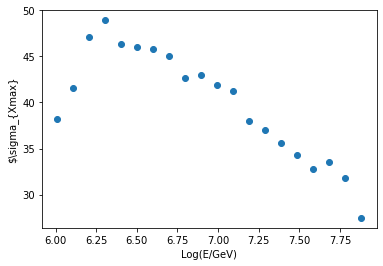

In [31]:
plt.scatter(bins,std_mean)
plt.xlabel('Log(E/GeV)')
plt.ylabel('$\\sigma_{Xmax}')
plt.savefig('sigma_Xmax.png')

In [32]:
import seaborn as sns

In [33]:
energy_values = np.linspace(6.5,8.0,11)

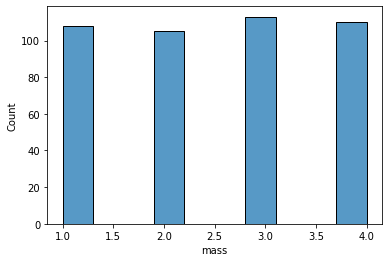

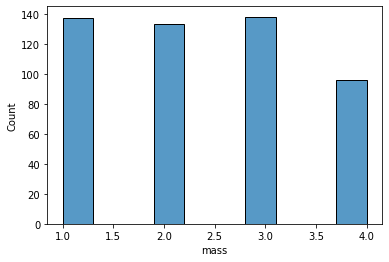

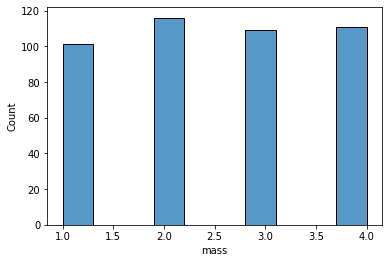

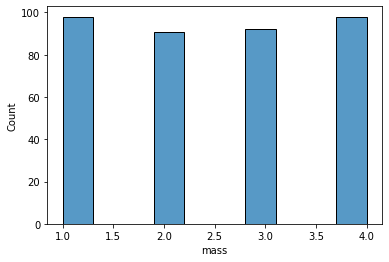

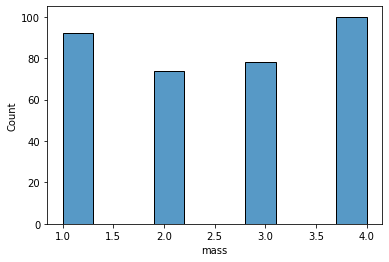

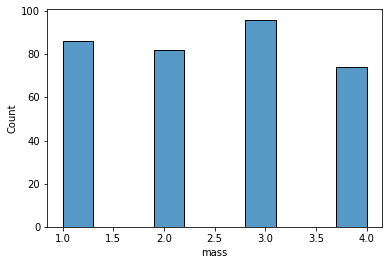

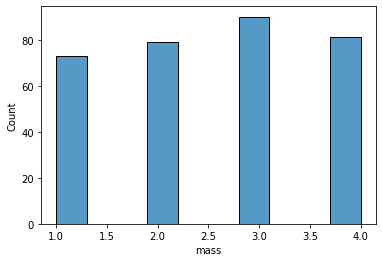

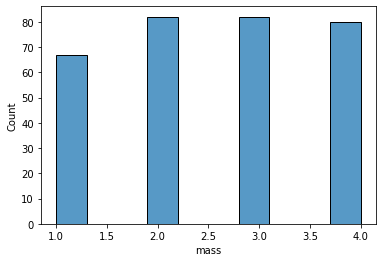

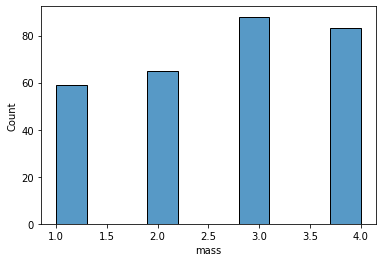

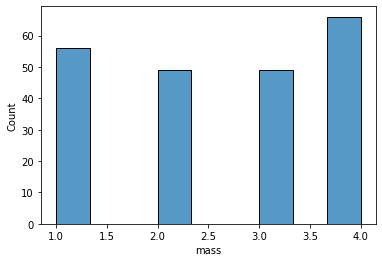

In [34]:
for index,values in enumerate(energy_values[0:-1]):
    values = np.array(list(zip(test_data['mass'].values,test_data['Xmax'].values,test_data['log_energy'].values)))
    check = (test_data['log_energy'].values>=energy_values[index])&(test_data['log_energy'].values<energy_values[index+1])
    df_check = test_data[check]
    sns.histplot(df_check,x='mass')
    plt.show()

In [35]:
files2 = glob.glob('files/kde_plots_*')

In [36]:
energy_stuff = ['6.5 - 6.65', '6.65 - 6.8', '6.8 - 6.95', '6.95 - 7.1', '7.1 - 7.25', '7.25 - 7.4', '7.4 - 7.55', '7.55 - 7.7', '7.7 - 7.85', '7.85 - 8.0']

In [37]:
def kde_model(x,species,energy_max,energy_min):
    check = (test_energy>=energy_min) & (test_energy<energy_max) & (test_mass == species)
    true = test_data['Xmax'].values[check]
    error = [abs(i-j)for i,j in zip(true,test_xmax[check])]
    model = scipy.stats.gaussian_kde(test_xmax[check],weights = 1/test_data['new_waveform_weight'].values[check])

    return np.array([model.evaluate(i) for i in x])

In [38]:
Energy_range = np.linspace(400,800,1000)
mass_range = np.linspace(0,5,1000)

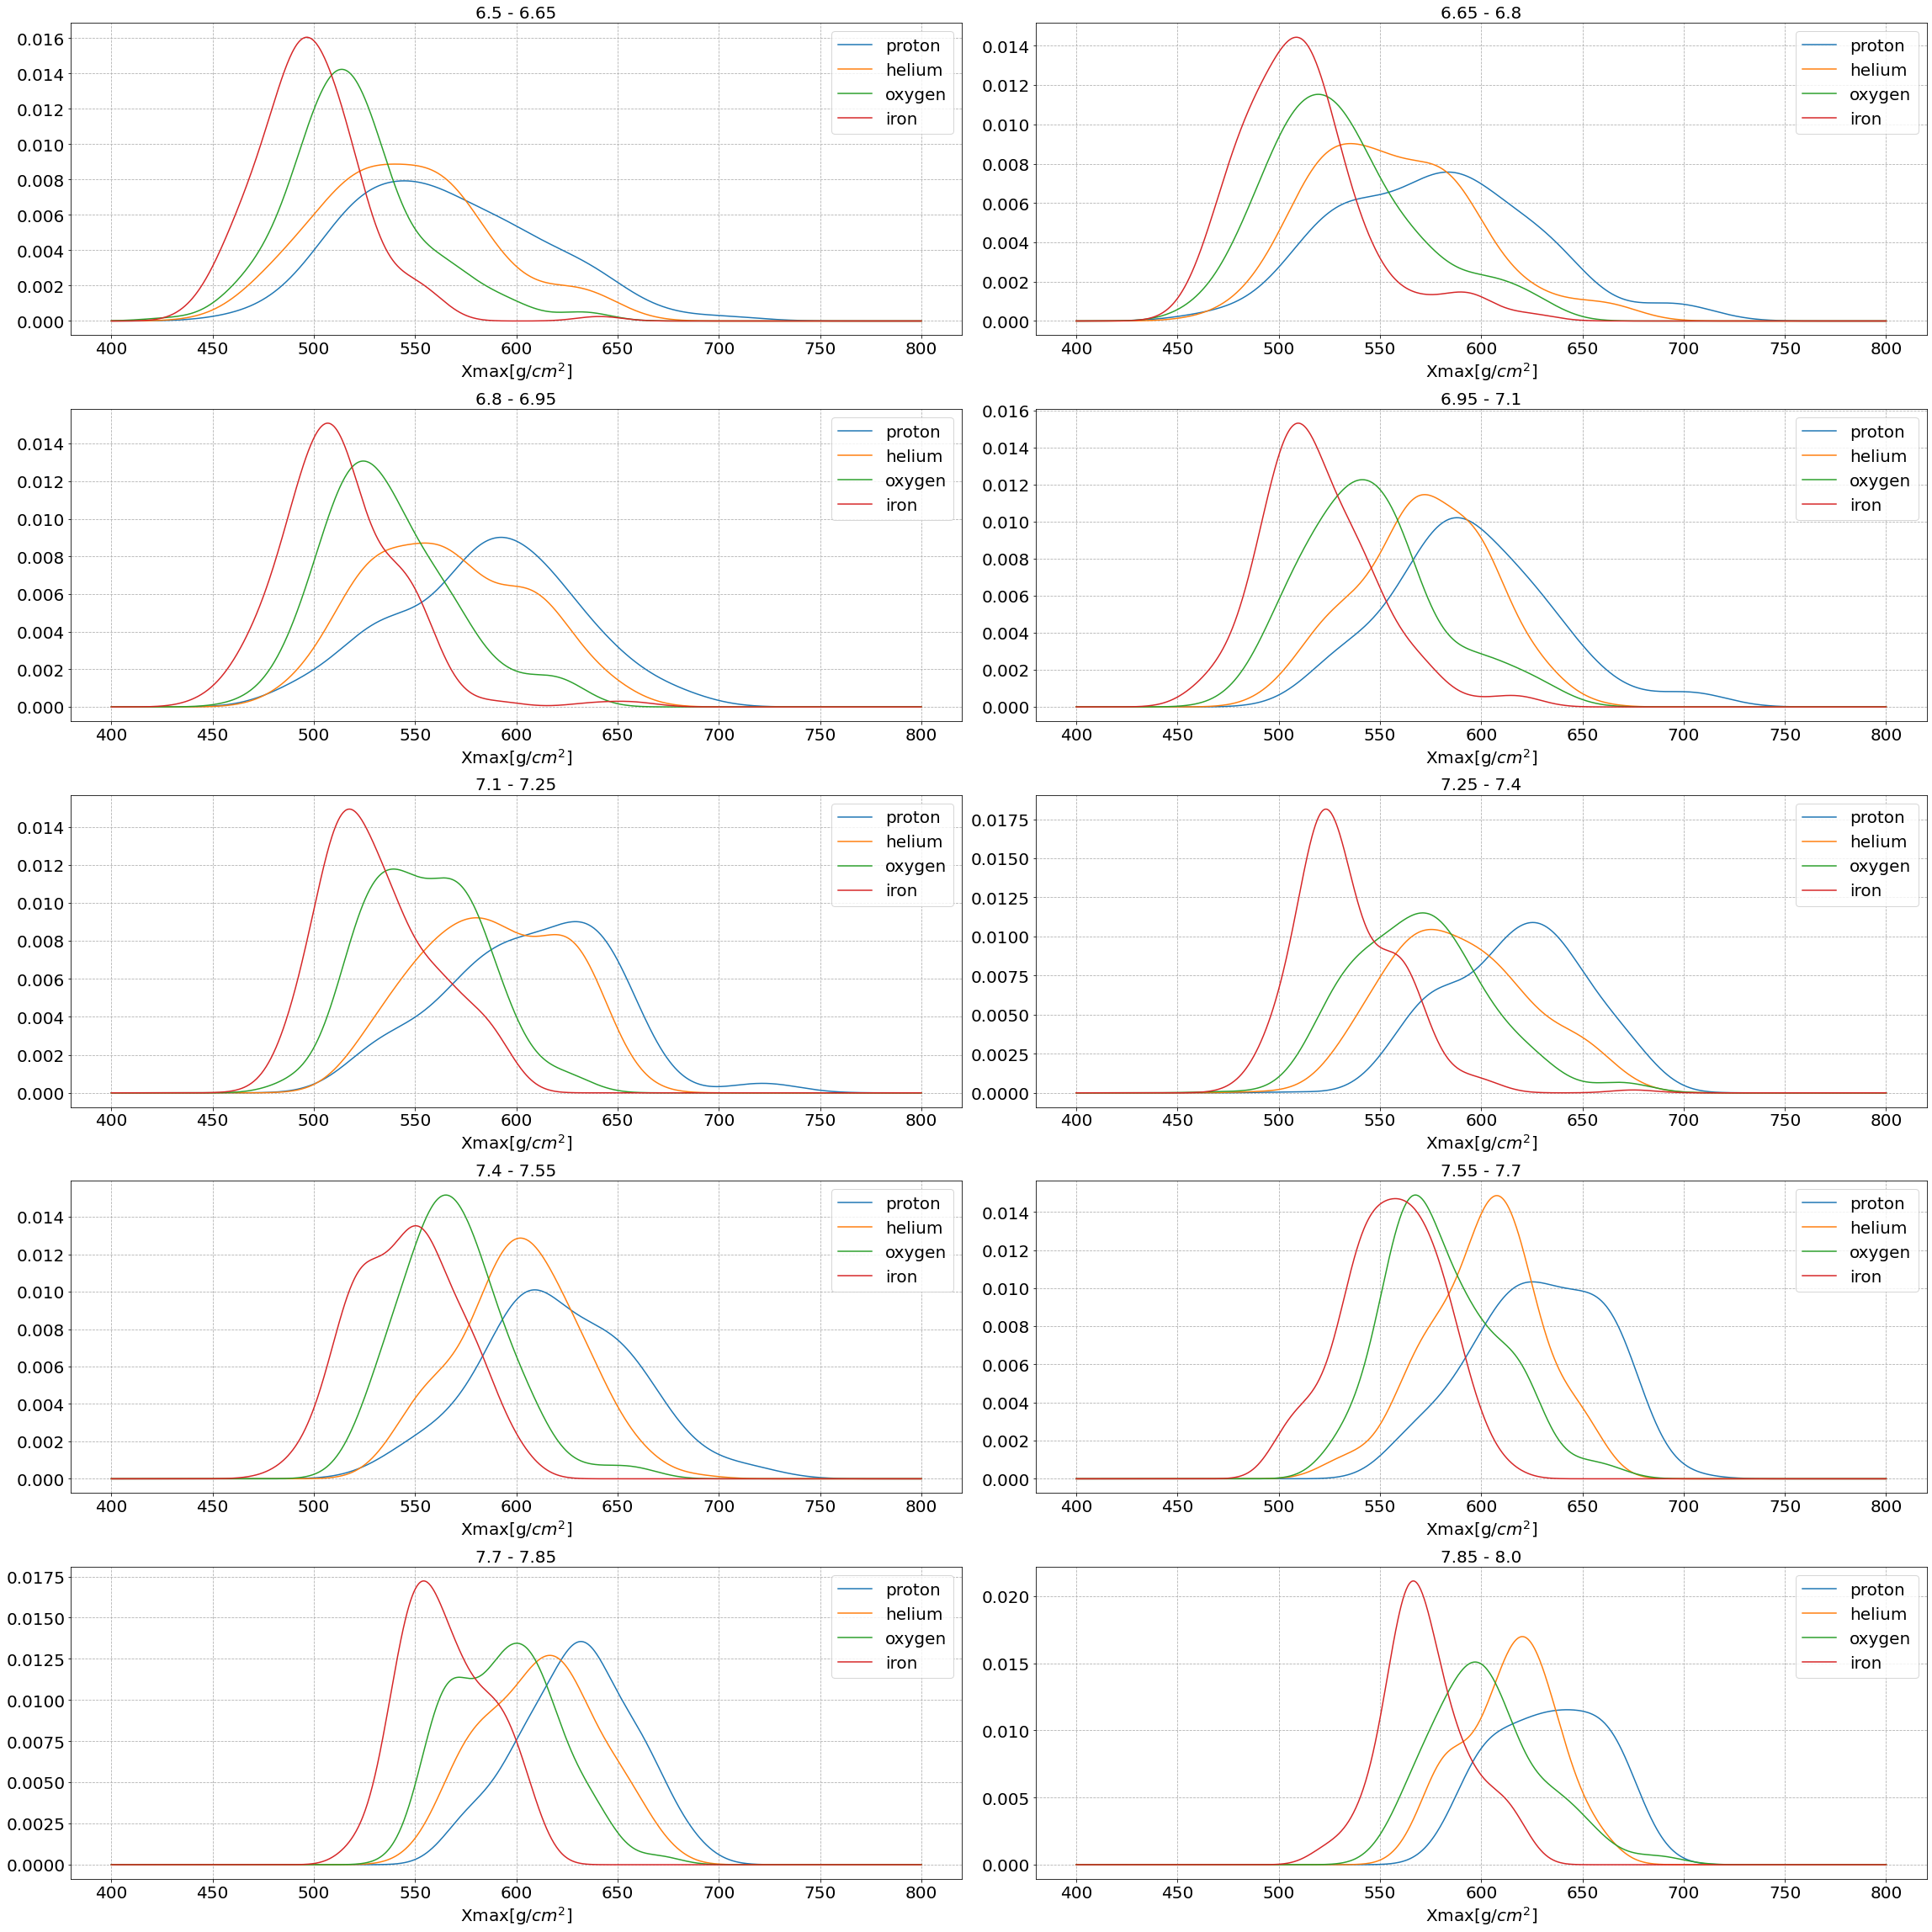

In [39]:
fig,axs = plt.subplots(5,2,figsize=(32,16*2))
count = 0
count2 = 0
for index,values in enumerate(energy_values[0:-1]):
    kde_plot_proton = kde_model(Energy_range,species=1,energy_max = energy_values[index+1], energy_min = energy_values[index])
    kde_plot_helium = kde_model(Energy_range,species=2,energy_max = energy_values[index+1], energy_min = energy_values[index])
    kde_plot_oxygen = kde_model(Energy_range,species=3,energy_max = energy_values[index+1], energy_min = energy_values[index])
    kde_plot_iron = kde_model(Energy_range,species=4,energy_max = energy_values[index+1], energy_min = energy_values[index])
    
    axs[count][count2].plot(Energy_range,kde_plot_proton,label='proton')
    axs[count][count2].plot(Energy_range,kde_plot_helium,label='helium')
    axs[count][count2].plot(Energy_range,kde_plot_oxygen,label='oxygen')
    axs[count][count2].plot(Energy_range,kde_plot_iron,label='iron')
    axs[count][count2].set_title('%s - %s'%(energy_values[index],energy_values[index+1]),fontsize = 20)
    axs[count][count2].legend(fontsize = 20)
    axs[count][count2].grid(True,linestyle='dashed')
    axs[count][count2].tick_params(labelsize = 20)
    axs[count][count2].set_xlabel('Xmax[g/$cm^2$]',fontsize = 20)
    
    count2 += 1
    if count2 == 2:
        count2 = 0
        count += 1
plt.tight_layout()
plt.savefig('Xmax_kde_plots.png')

In [40]:
def xmax_kde(x,a,b,c,d,energy_max,energy_min):
    return a * kde_model(x,species=1,energy_max=energy_max, energy_min=energy_min) + b * kde_model(x,species=2,energy_max=energy_max, energy_min=energy_min) + c * kde_model(x,species=3,energy_max=energy_max, energy_min=energy_min) + d * kde_model(x,species=4,energy_max=energy_max, energy_min=energy_min)

In [41]:
def mse(f_obs,f_exp):
    return np.mean([(i-j)**2 for i,j in zip(f_obs,f_exp)])

In [42]:
def chisquare(obs, exp, error):
    return np.sum((obs - exp) ** 2 / (error ** 2))

In [43]:
from scipy.stats import chi2

In [44]:
def plot_model(model,name,bin_value,plot = False):
    if plot:
        fig,axs = plt.subplots(5,2,figsize=(32,16*2))

    count = 0
    count2 = 0
    
    num_bins = [bin_value]
    
    energy_bin = []
    chi2_list = [[]]

    count_new = 0
    
    
    for index,values in enumerate(energy_values[0:-1]):
        energy_max = energy_values[index+1]
        energy_min = energy_values[index]
    
        my_function = partial(xmax_kde,energy_max = energy_max, energy_min = energy_min)
    
        counts,bins = np.histogram(xmax_data[(energy_data>=energy_min)&(energy_data<energy_max)],bins=num_bins[0])
      
        energy  = 10**np.mean([energy_min,energy_max])
        
        sum_flux = model.nucleus_flux(14,energy) + model.nucleus_flux(402,energy) + model.nucleus_flux(1206,energy) + model.nucleus_flux(5426,energy)
        proton_frac = model.nucleus_flux(14,energy)/sum_flux
        helium_frac = model.nucleus_flux(402,energy)/sum_flux
        oxygen_frac = model.nucleus_flux(1206,energy)/sum_flux
        iron_frac = model.nucleus_flux(5426,energy)/sum_flux
        
        area = np.sum(counts) * (bins[1] - bins[0])
        error = np.array([(i**0.5)/area for i in counts])
    
        energy_bin.append(np.mean([energy_min,energy_max]))
        
        bins_mean = []
        for i in range(len(bins)-1):
            bins_mean.append(np.mean([bins[i],bins[i+1]]))
        
        sum_kde = my_function(bins_mean,proton_frac,helium_frac,oxygen_frac,iron_frac)
        value = chisquare(np.hstack(sum_kde)[error>0],counts[error>0]/area,error = error[error>0])
        chi2_list[count_new].append(value)
        
        if plot:
            axs[count][count2].errorbar(bins_mean,counts/area,label='data',color='black',fmt = 'o',yerr = error)
            axs[count][count2].plot(bins_mean,my_function(bins[0:-1],proton_frac,helium_frac,oxygen_frac,iron_frac),label='fit',linestyle = 'dashed')
            axs[count][count2].plot(bins_mean,proton_frac* kde_model(bins_mean,species=1,energy_max=energy_max, energy_min=energy_min),label='proton')
            axs[count][count2].plot(bins_mean,helium_frac* kde_model(bins_mean,species=2,energy_max=energy_max, energy_min=energy_min),label='helium')
            axs[count][count2].plot(bins_mean,oxygen_frac* kde_model(bins_mean,species=3,energy_max=energy_max, energy_min=energy_min),label='oxygen')
            axs[count][count2].plot(bins_mean,iron_frac* kde_model(bins_mean,species=4,energy_max=energy_max, energy_min=energy_min),label='iron')
            axs[count][count2].legend(fontsize = 20)
            axs[count][count2].tick_params(labelsize = 20)
            axs[count][count2].set_xlabel('Xmax[g/$cm^2$]',fontsize = 20)
            axs[count][count2].grid(linestyle = '--')
            axs[count][count2].set_title('Energy: %.2f - %.2f, Proton: %.2f, Helium: %.2f, Oxygen: %.2f, Iron: %.2f'%(energy_min,energy_max,proton_frac,helium_frac,oxygen_frac,iron_frac),fontsize = 20)
    
        count2 += 1
        if count2 == 2:
            count2 = 0
            count += 1
    if plot:    
        plt.tight_layout()
        plt.savefig(name)
    
    return energy_bin,chi2_list

In [45]:
def get_values(my_list):
    output = [[] for i in range(len(my_list[0][0]))]
    for i in range(len(my_list)):
        for j in range(len(my_list[0][0])):
            output[j].append(my_list[i][0][j])
    return output

In [46]:
from sklearn.utils import resample

In [47]:
def resample_method(input_value):
    mean_value = []
    for i in range(5000):
        new_one = resample(input_value)
        mean_value.append(np.mean(new_one))
    return mean_value

In [48]:
H3A_chi2 = []
for i in [50]:
    energy_bin,chi2_list = plot_model(H3A,'H3A_fit.png',bin_value=i)
    H3A_chi2.append(chi2_list)

([6.575, 6.725, 6.875, 7.025, 7.175, 7.325, 7.475, 7.625, 7.775, 7.925],
 [[164.5247483213518,
   311.38605963001066,
   145.97085194997368,
   195.16087519617233,
   111.76841162856861,
   223.51320433579187,
   77.21156829961089,
   49.18478086114609,
   46.027369570529544,
   43.63181244937224]])

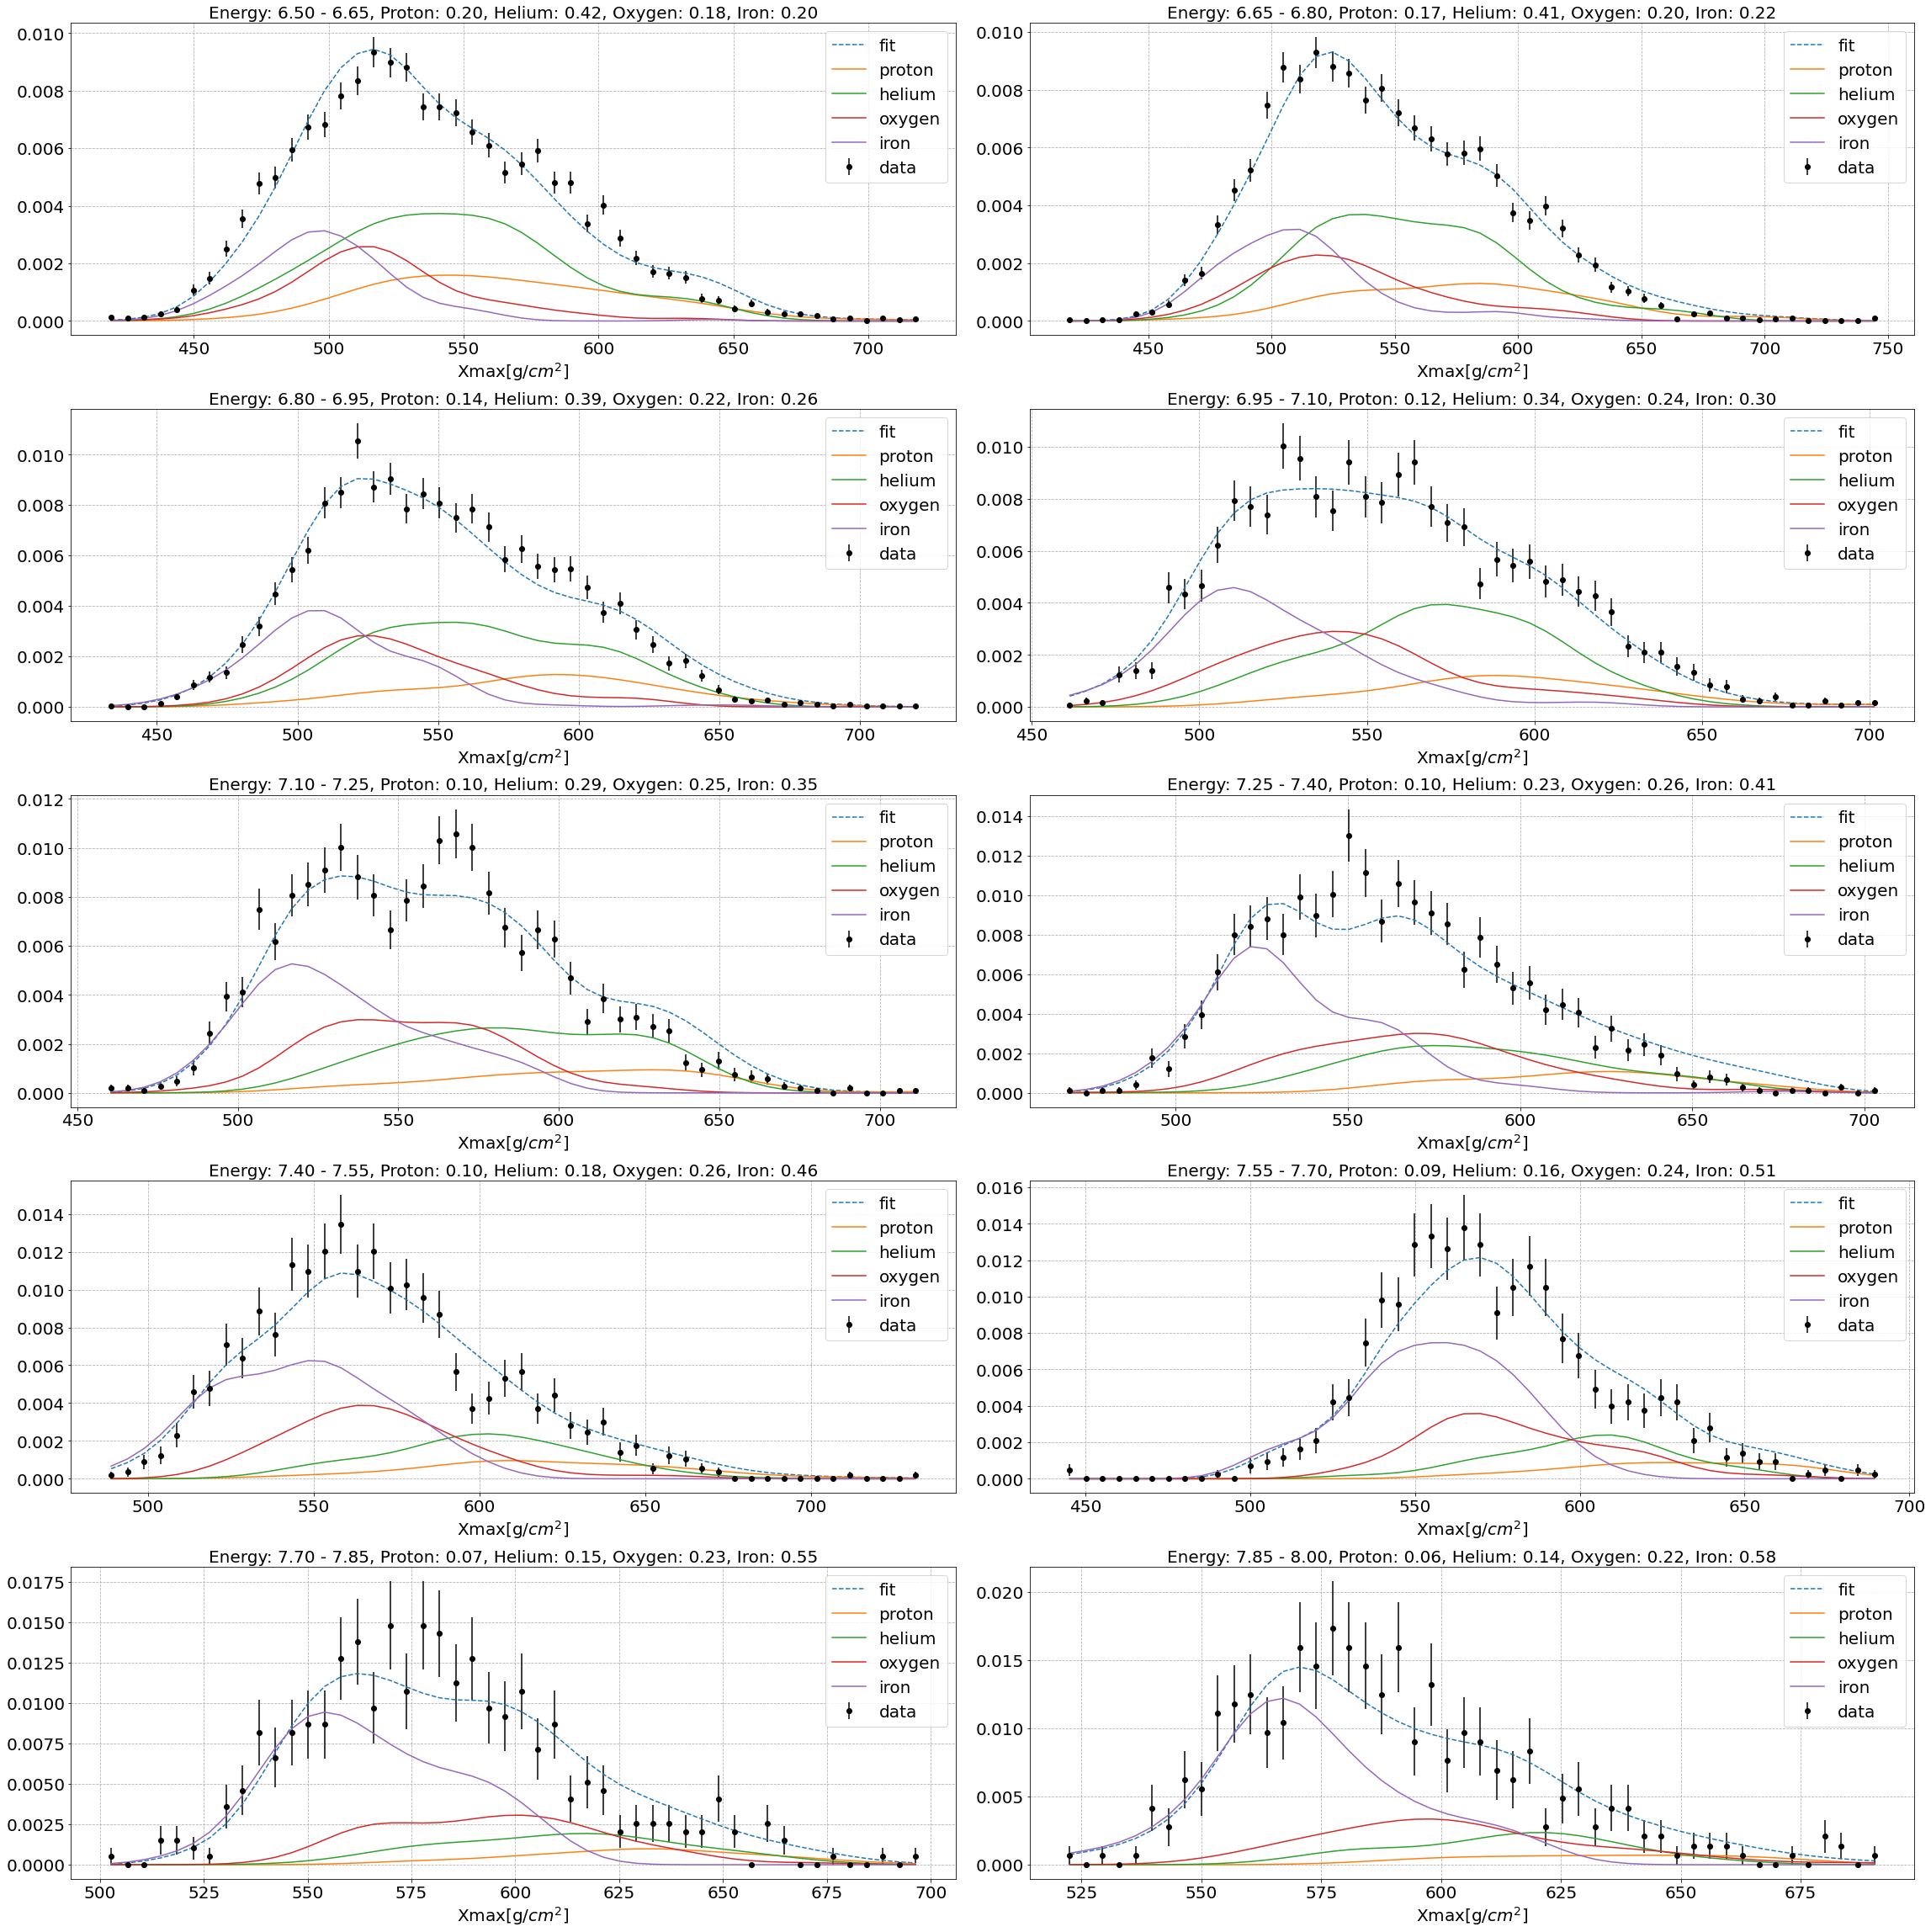

In [49]:
plot_model(H3A,'H3A_fit.png',bin_value=50,plot=True)

In [50]:
H3A_chi2_mean = [np.mean(i) for i in get_values(H3A_chi2)]
H3A_std = [np.std(i) for i,j in zip(get_values(H3A_chi2),H3A_chi2_mean)]

In [51]:
H4A_chi2 = []
for i in [50]:
    energy_bin,chi2_list = plot_model(H4A,'H4A_fit.png',bin_value=i)
    H4A_chi2.append(chi2_list)

([6.575, 6.725, 6.875, 7.025, 7.175, 7.325, 7.475, 7.625, 7.775, 7.925],
 [[160.94795810963726,
   333.4335053400896,
   154.39060296174085,
   178.43262495770907,
   138.57400900712975,
   286.8914476538401,
   89.67578706121,
   77.43546675636179,
   52.99206819988116,
   55.61509398722789]])

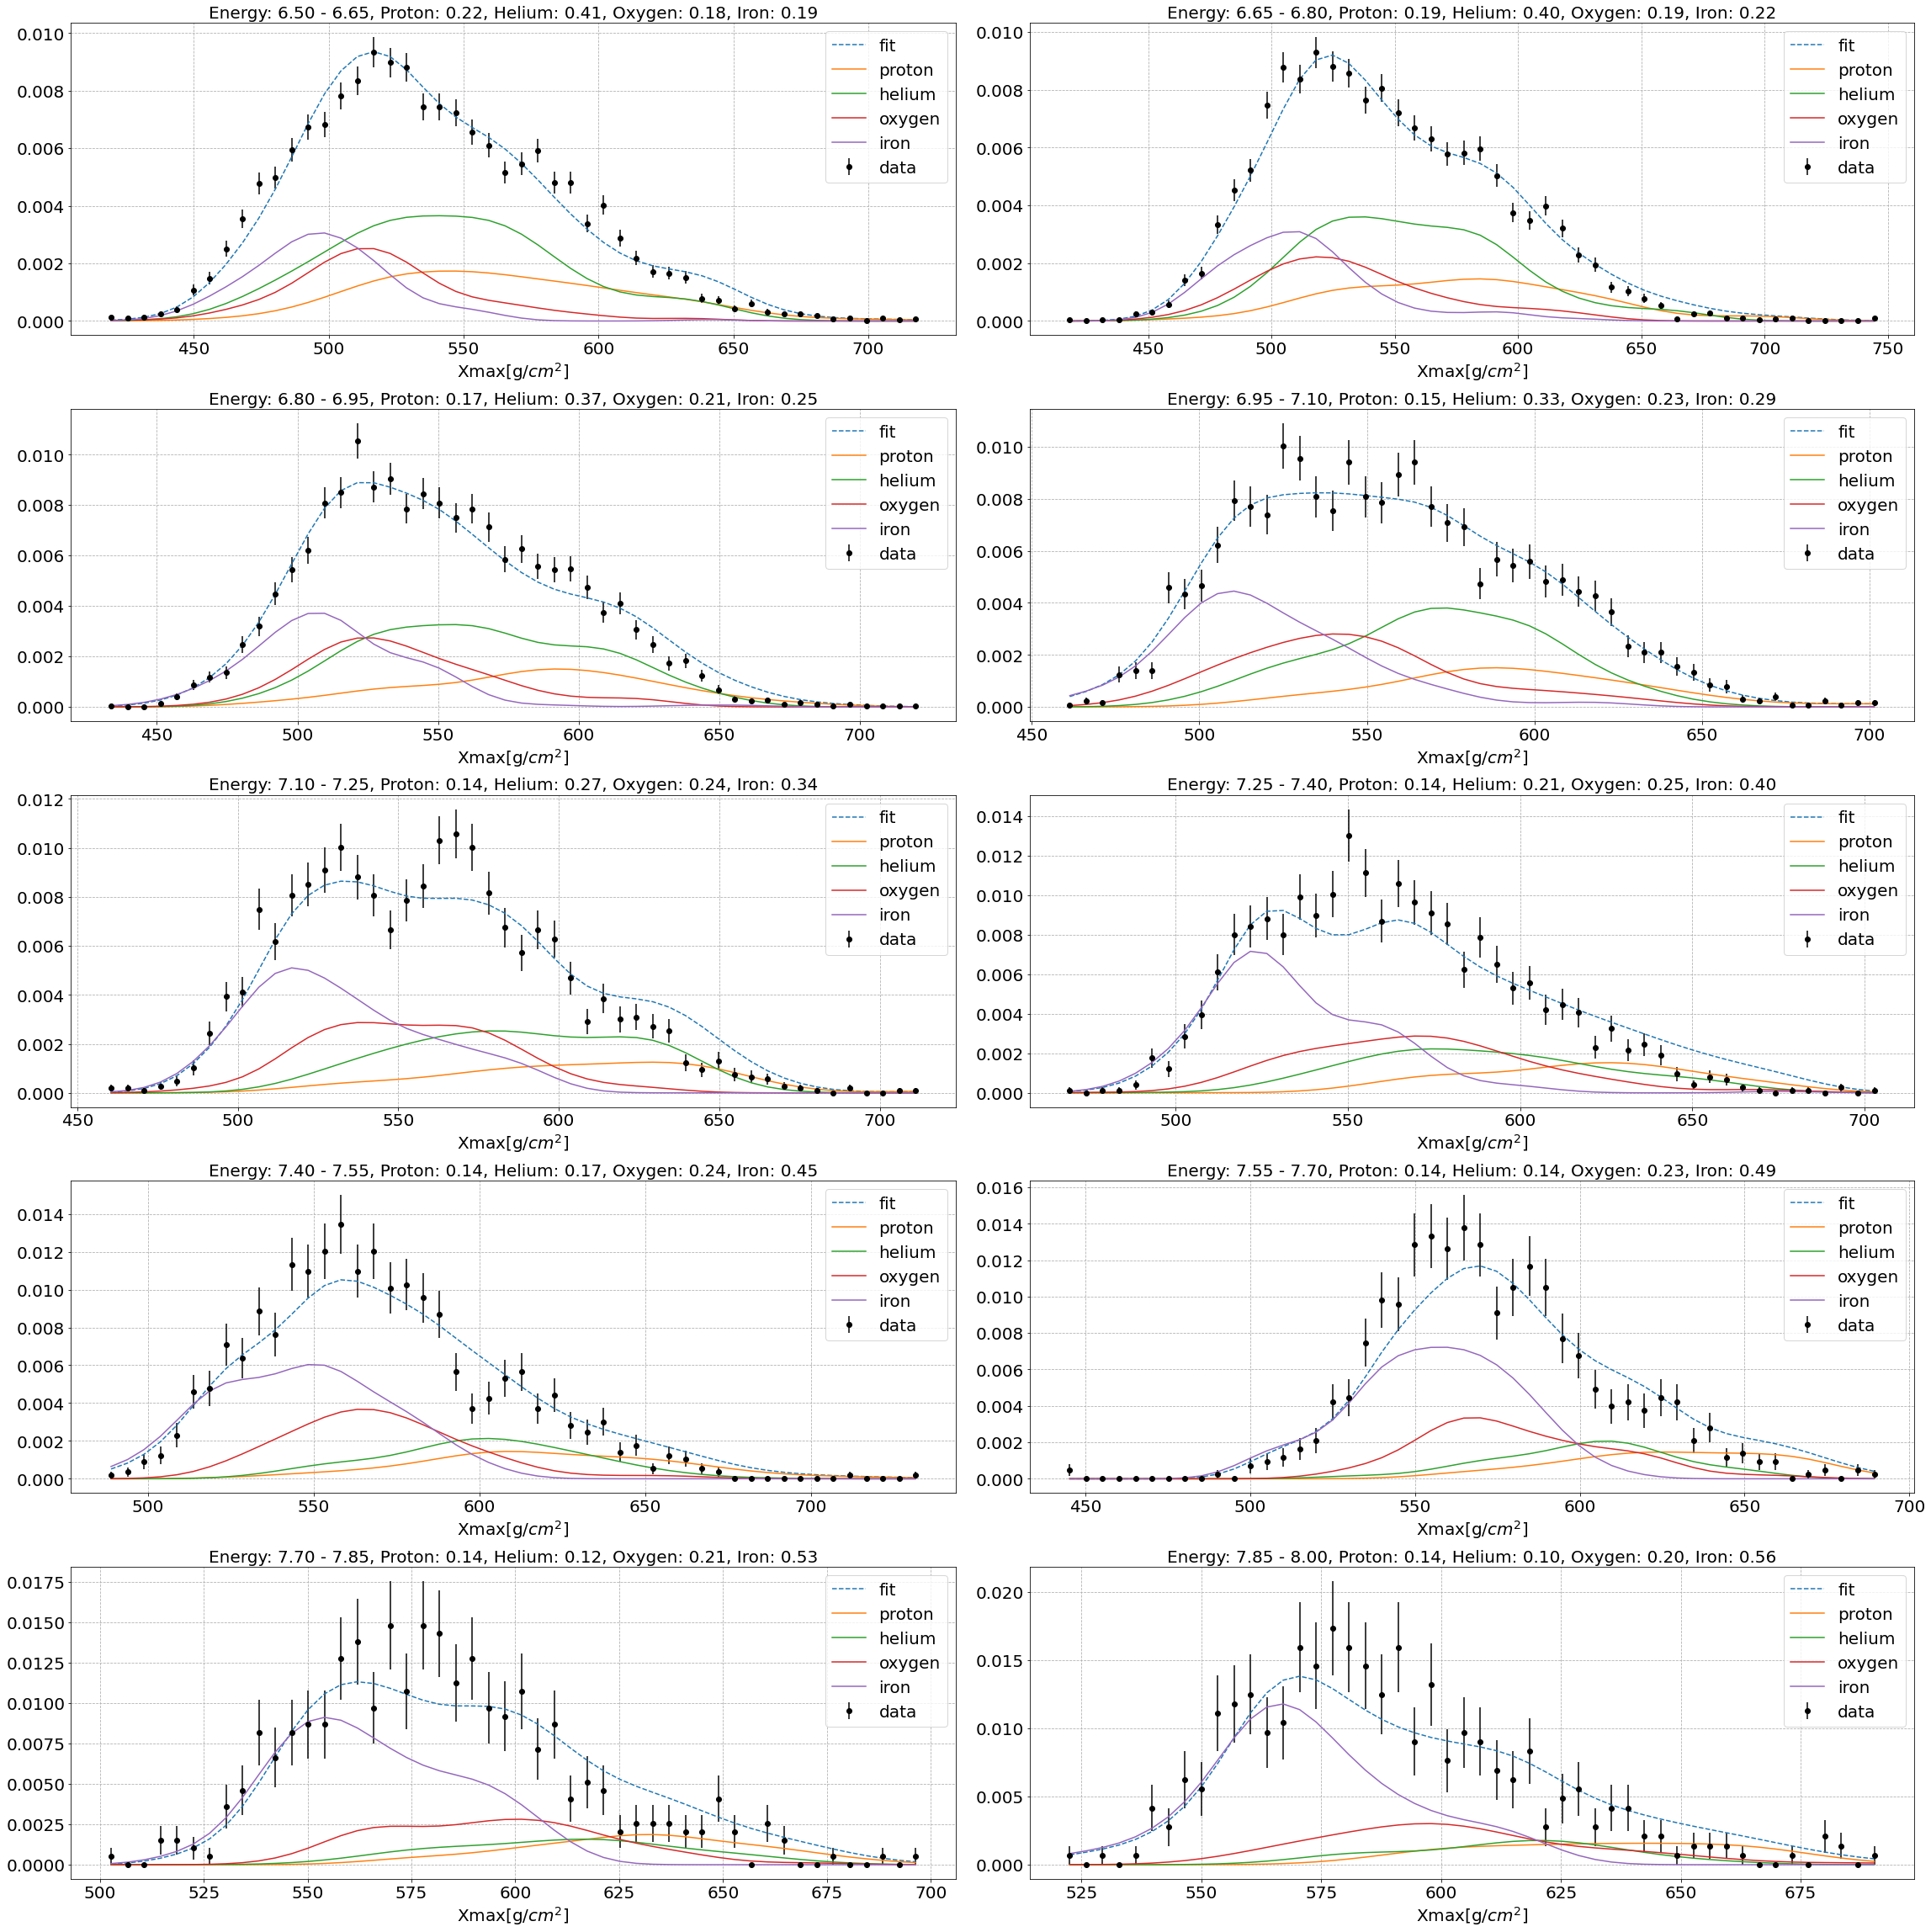

In [52]:
plot_model(H4A,'H4A_fit.png',bin_value=50,plot=True)

In [53]:
H4A_chi2_mean = [np.mean(i) for i in get_values(H4A_chi2)]
H4A_std = [np.std(i) for i,j in zip(get_values(H4A_chi2),H4A_chi2_mean)]

In [54]:
GST_chi2 = []
for i in [50]:
    energy_bin,chi2_list = plot_model(GST,'GST_fit.png',bin_value=i)
    GST_chi2.append(chi2_list)

([6.575, 6.725, 6.875, 7.025, 7.175, 7.325, 7.475, 7.625, 7.775, 7.925],
 [[232.40286051886372,
   360.29679659699883,
   173.77510334805194,
   186.3417861305237,
   202.20148686777193,
   319.96469874523183,
   133.79325351896378,
   110.29652653349025,
   59.13541634601597,
   74.49439296816577]])

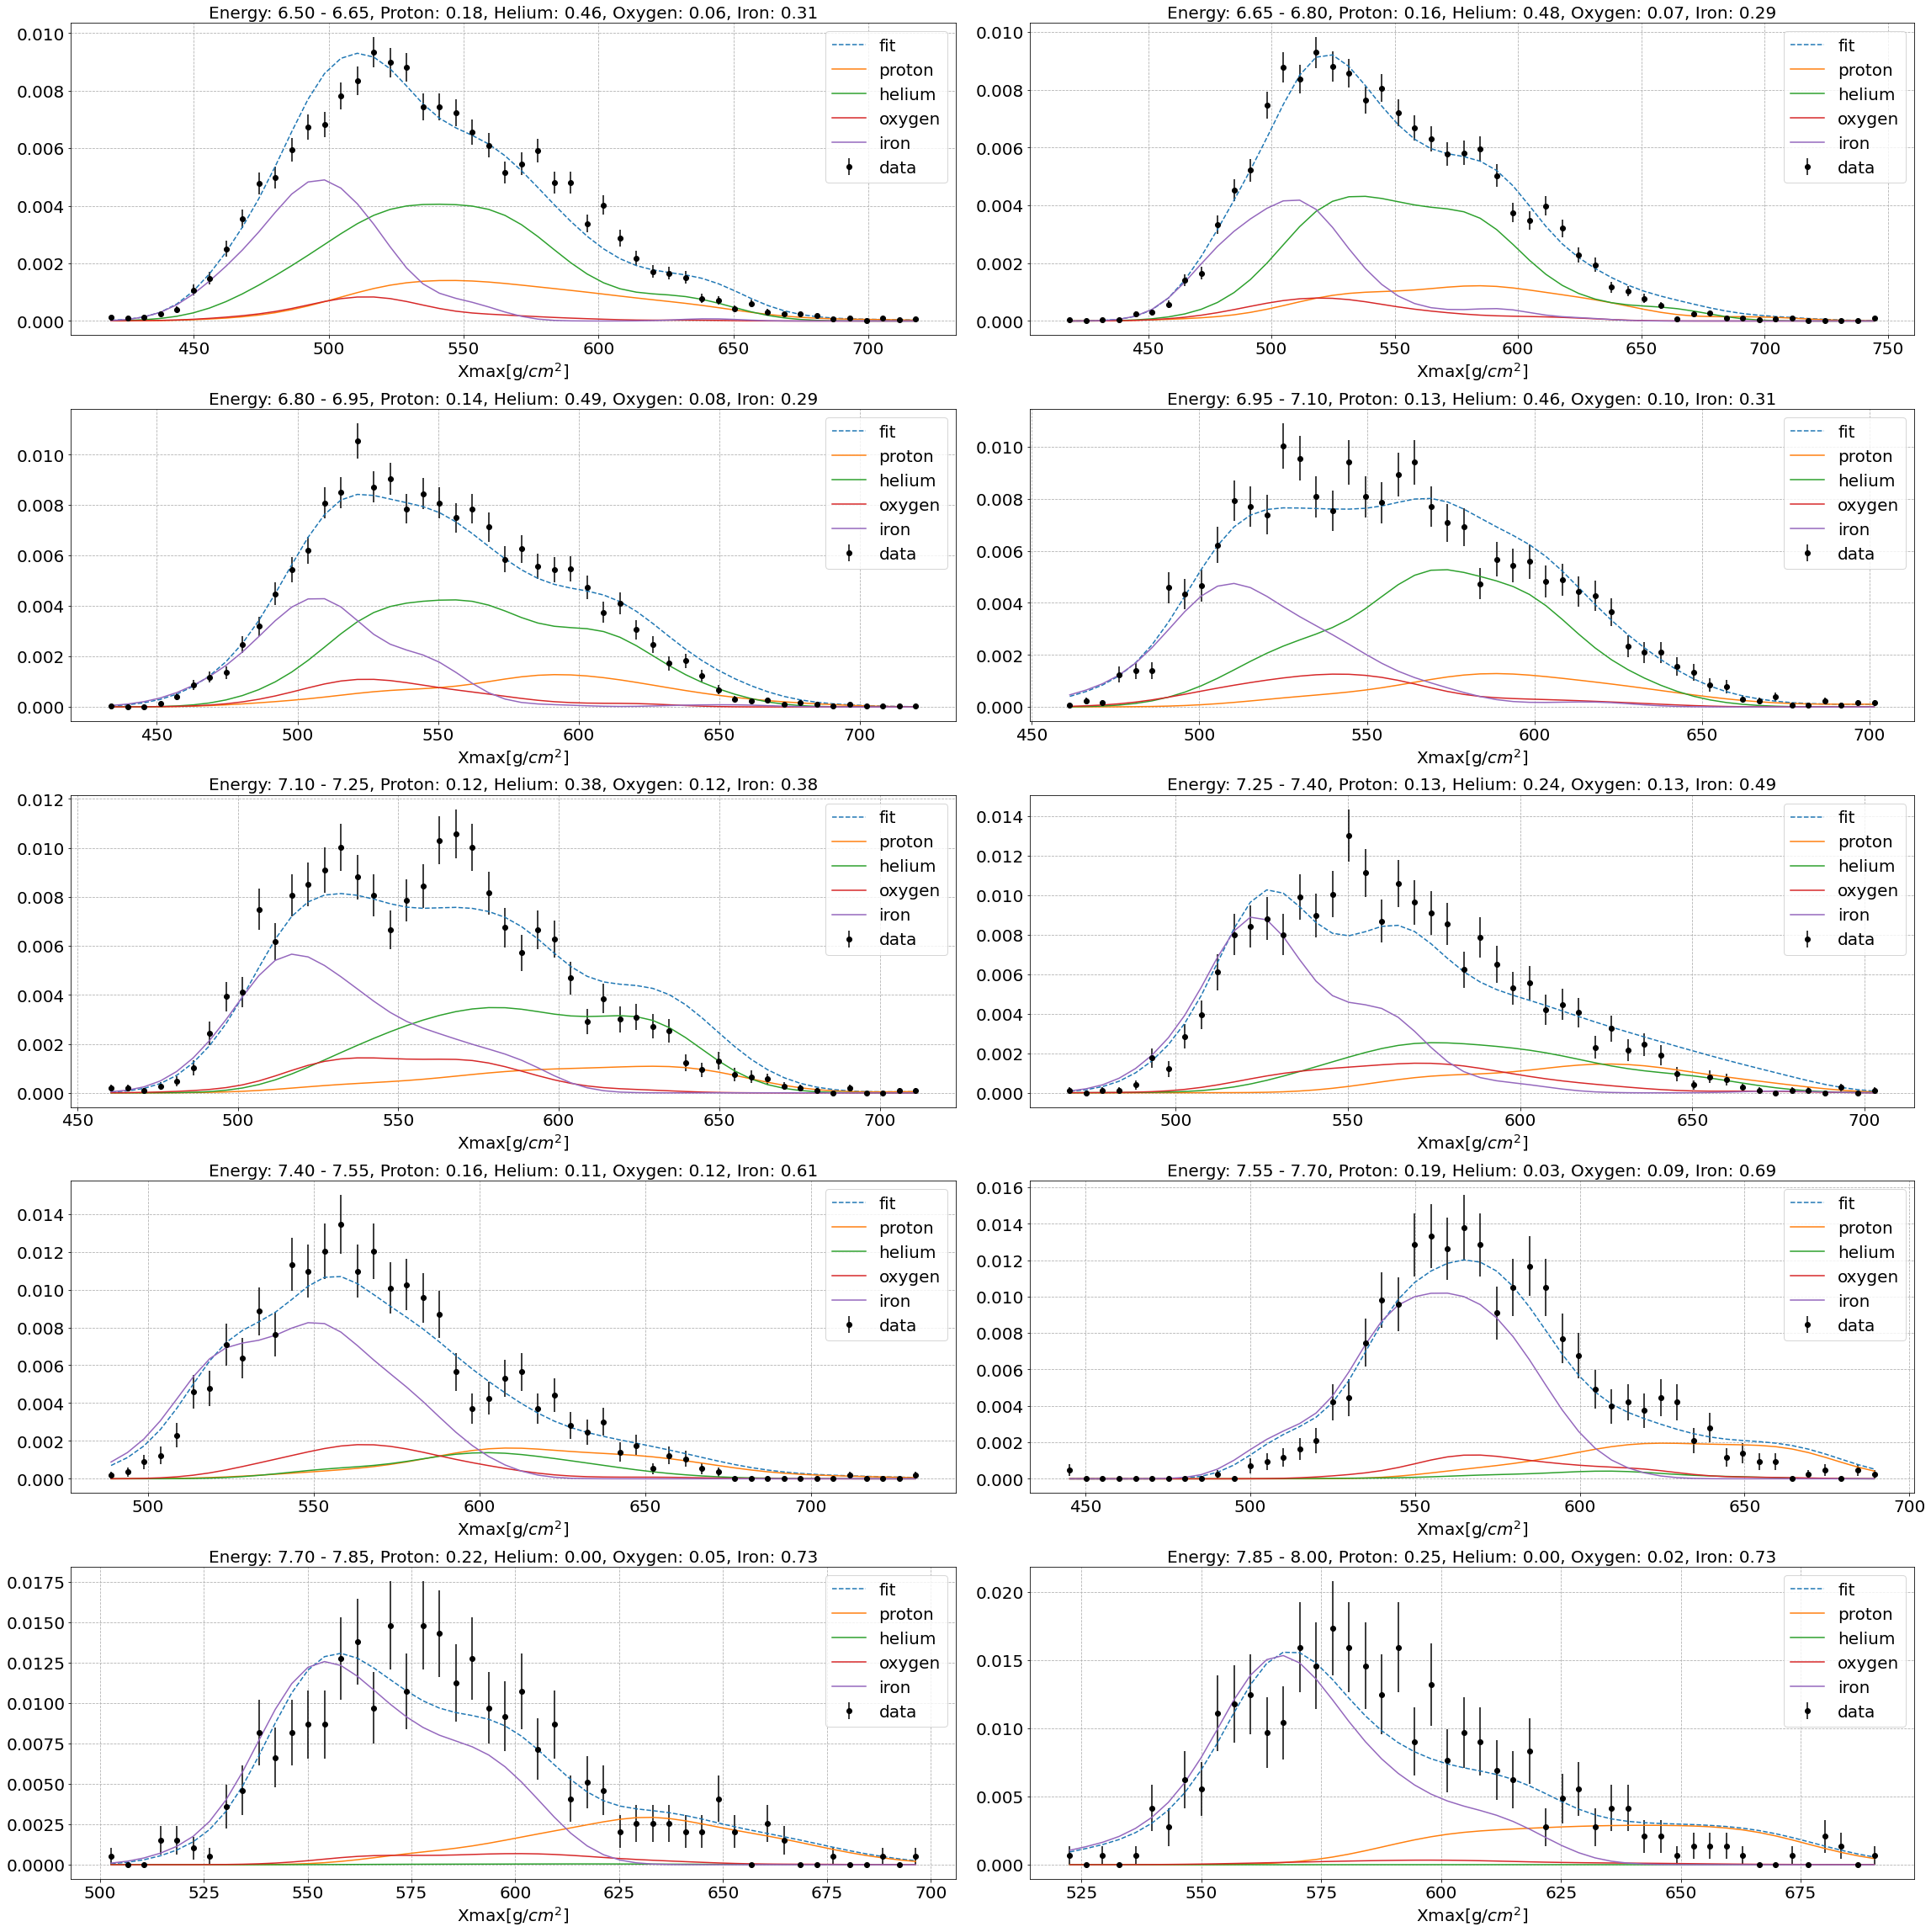

In [55]:
plot_model(GST,'GST_fit.png',bin_value=50,plot=True)

In [56]:
GST_chi2_mean = [np.mean(i) for i in get_values(GST_chi2)]
GST_std = [np.std(i) for i,j in zip(get_values(GST_chi2),GST_chi2_mean)]

In [57]:
G3gen_chi2 = []
for i in [50]:
    energy_bin,chi2_list = plot_model(mods.GaisserStanevTilav('3-gen'),'GH_fit.png',bin_value=i)
    G3gen_chi2.append(chi2_list)

In [58]:
G3gen_chi2_mean = [np.mean(i) for i in get_values(G3gen_chi2)]
G3gen_std = [np.std(i) for i,j in zip(get_values(G3gen_chi2),G3gen_chi2_mean)]

([6.575, 6.725, 6.875, 7.025, 7.175, 7.325, 7.475, 7.625, 7.775, 7.925],
 [[242.71271672143226,
   361.8353324475762,
   181.0557381050451,
   199.5502949845113,
   189.69375769978842,
   324.24469307397123,
   140.93800311080065,
   109.9042705641257,
   60.332299604223785,
   72.43574774958239]])

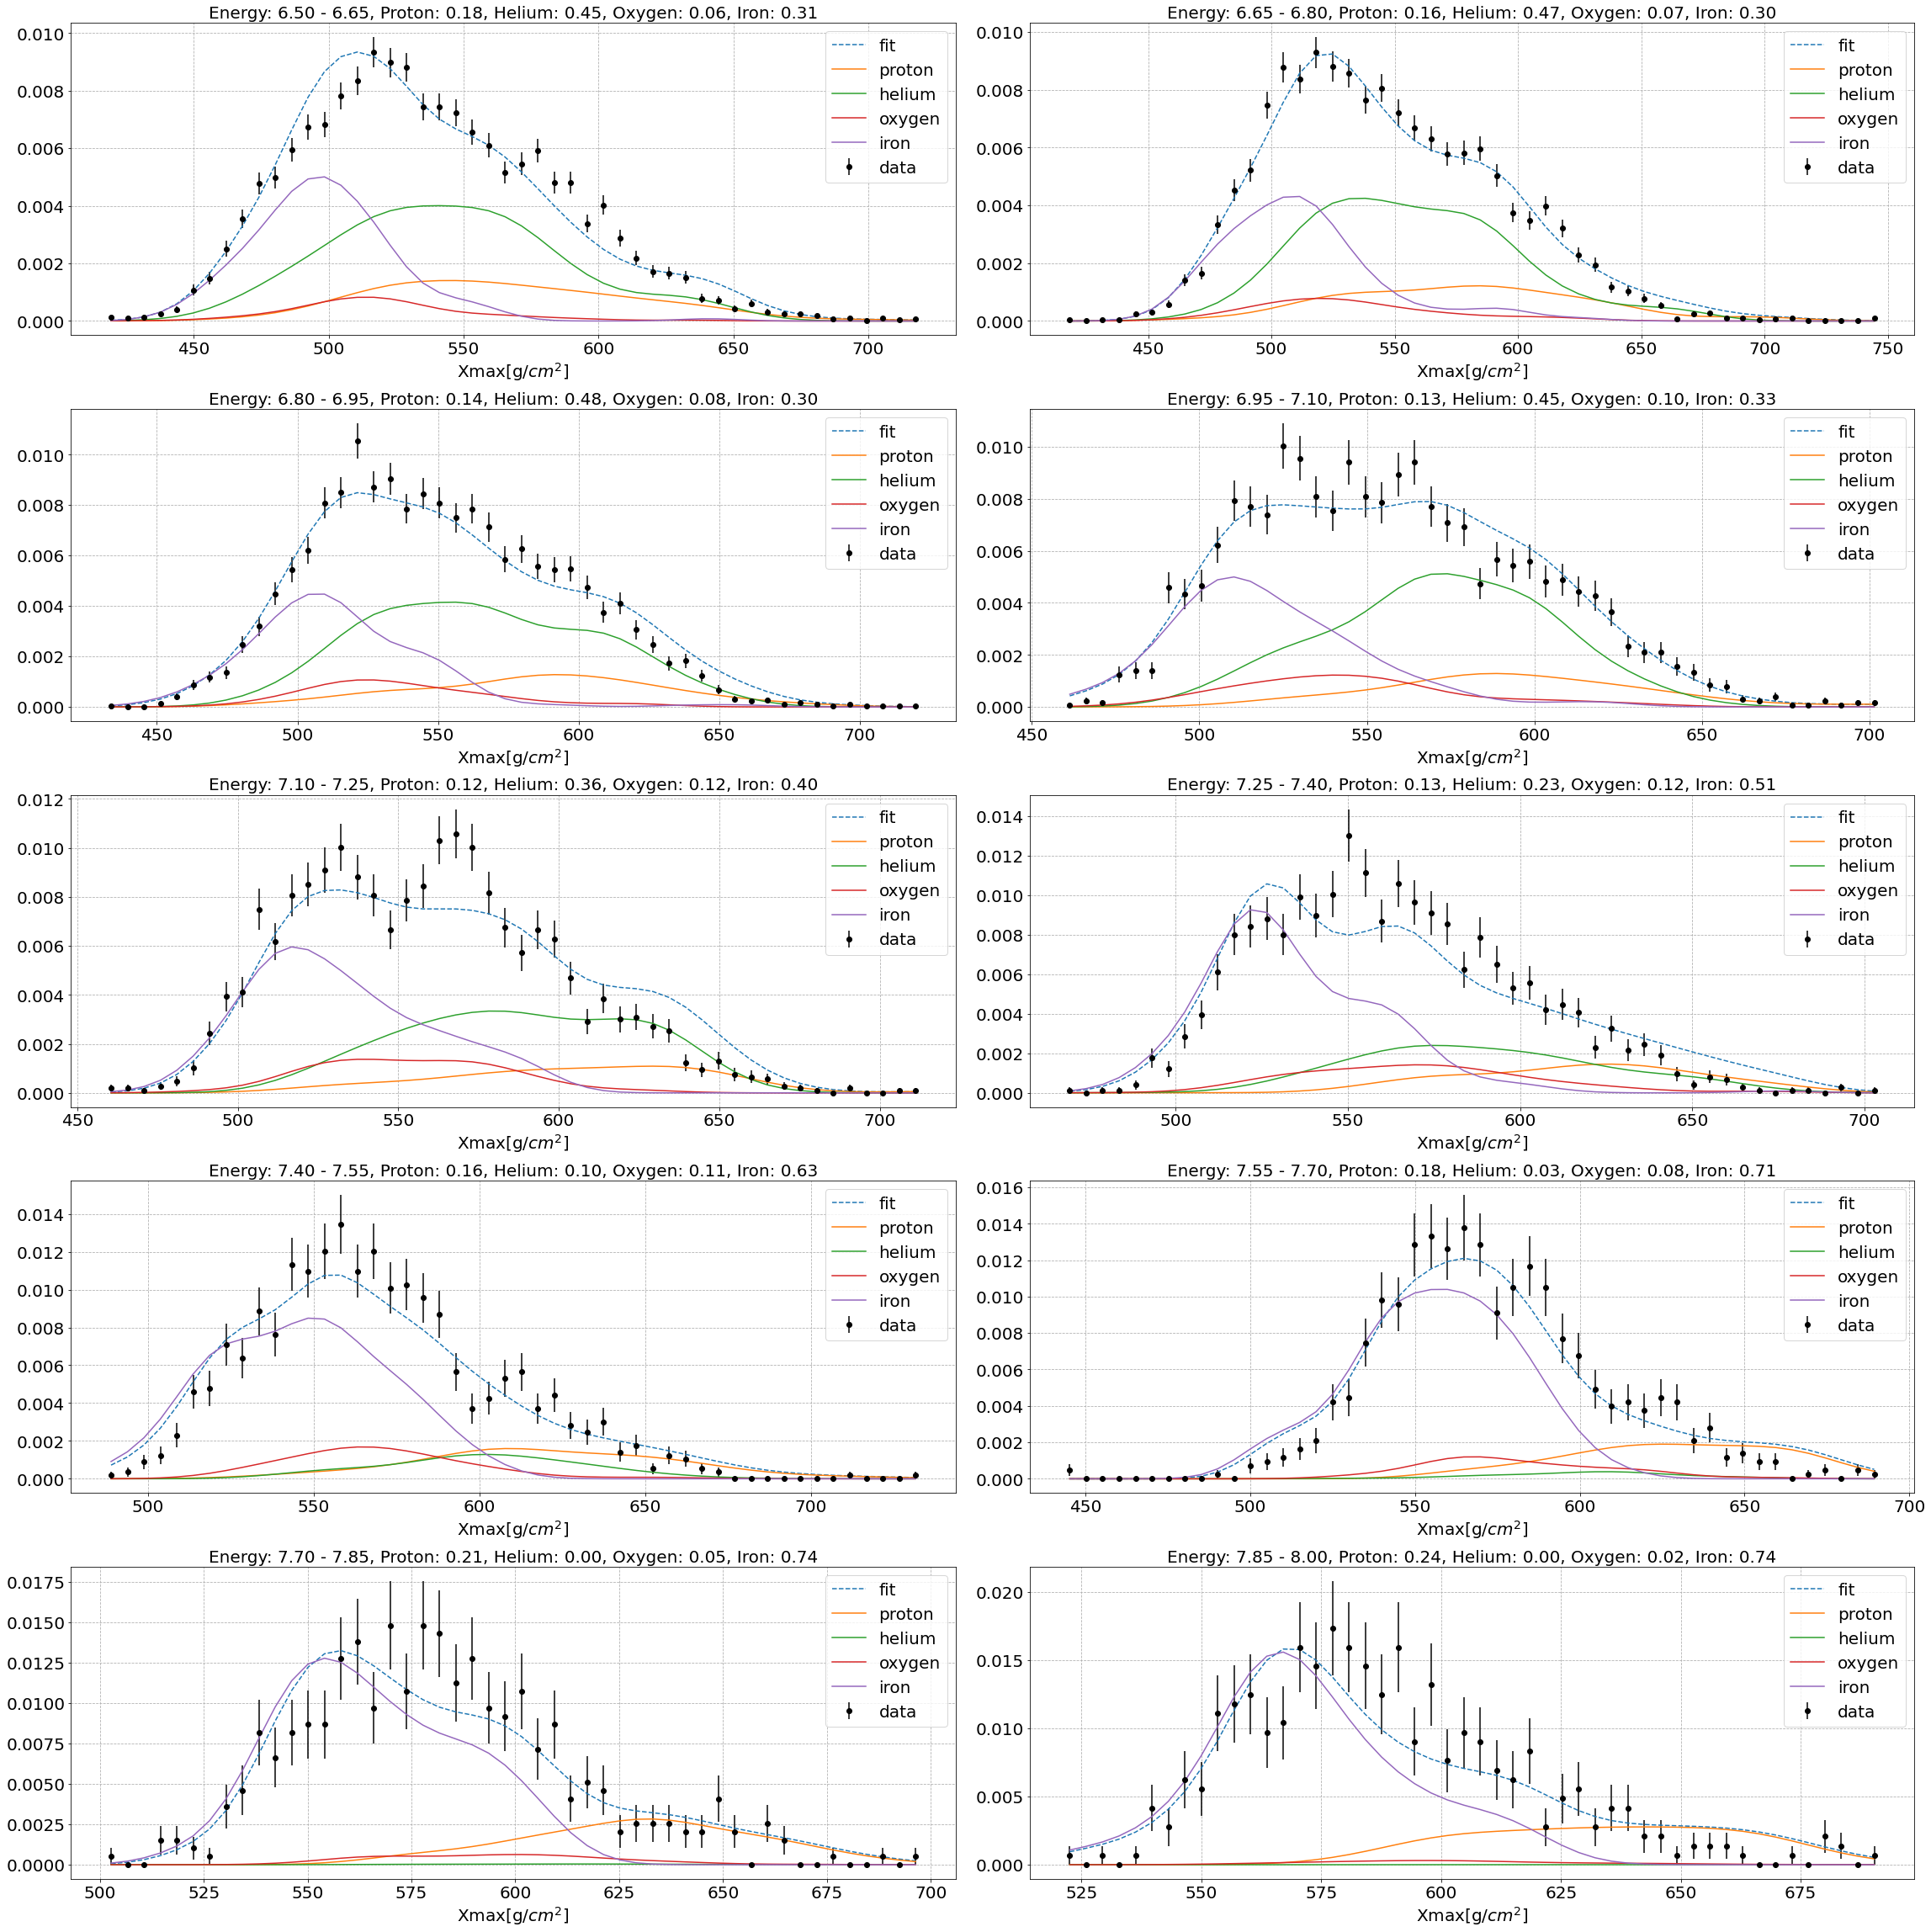

In [59]:
plot_model(mods.GaisserStanevTilav('3-gen'),'GST_3gen_fit.png',bin_value=50,plot=True)

In [60]:
output_dict = {'log10(E/GeV)':energy_bin,'H3A':H3A_chi2_mean,'H4A':H4A_chi2_mean,'GST':GST_chi2_mean,'GST-3gen':G3gen_chi2_mean}

In [61]:
df_new = pd.DataFrame(output_dict)

In [62]:
df_new.head(10)

log10(E/GeV)         H3A         H4A         GST    GST-3gen
0         6.575  164.524748  160.947958  232.402861  242.712717
1         6.725  311.386060  333.433505  360.296797  361.835332
2         6.875  145.970852  154.390603  173.775103  181.055738
3         7.025  195.160875  178.432625  186.341786  199.550295
4         7.175  111.768412  138.574009  202.201487  189.693758
5         7.325  223.513204  286.891448  319.964699  324.244693
6         7.475   77.211568   89.675787  133.793254  140.938003
7         7.625   49.184781   77.435467  110.296527  109.904271
8         7.775   46.027370   52.992068   59.135416   60.332300
9         7.925   43.631812   55.615094   74.494393   72.435748

In [63]:
df_new.to_csv('chi2_values.csv',index = False,float_format='%.2f')
#df_new.to_csv('p_values.csv',index = False, float_format = '%.2E')